# Big Data Econometics Final Project: 
    - Problem: Use NLP methods to understand sentiment by analyzing FRB Beige Books.

In [1]:
import os, sys, time
import glob, re
import argparse

import pandas as pd
import numpy as np


In [2]:
from bs4 import BeautifulSoup
import nltk

#Download once if using NLTK for preprocessing
#nltk.download('punkt')

#Libraries for preprocessing
#from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
#from fuzzywuzzy import fuzz

#Libraries for clustering
from sklearn.cluster import KMeans


In [3]:
# Visualization

from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px


In [4]:
##pip install plotly

In [5]:
dirPath = os.getcwd()
dataDirectory = dirPath + "/data_html"
dataDirectory_err = dirPath + "/data_html_err"
resultDirectory = dirPath + "/result"
print(resultDirectory)
print(dataDirectory)
print(dataDirectory_err)

/Users/liqing/Desktop/ADAN7430/result
/Users/liqing/Desktop/ADAN7430/data_html
/Users/liqing/Desktop/ADAN7430/data_html_err


In [6]:
dirPath

'/Users/liqing/Desktop/ADAN7430'

In [7]:
lstFileNames = []
lstFileContentsInitial = []
files = glob.glob(os.path.join(dataDirectory, "*.html"))
for file in files:    
    # adding error handling
    try:
        with open(file, 'rb+') as f:
            # read the file as a string
            print("reading file: " + file)
            contents = f.read()
            print("read: " + str(len(contents)))
            lstFileContentsInitial.append(contents)  
        lstFileNames.append( os.path.basename(file))
    except:
        print("error reading file-*********" + os.path.basename(file))
        pass

reading file: /Users/liqing/Desktop/ADAN7430/data_html/199610.html
read: 96000
reading file: /Users/liqing/Desktop/ADAN7430/data_html/201909.html
read: 195009
reading file: /Users/liqing/Desktop/ADAN7430/data_html/200709.html
read: 125971
reading file: /Users/liqing/Desktop/ADAN7430/data_html/201509.html
read: 167257
reading file: /Users/liqing/Desktop/ADAN7430/data_html/199903.html
read: 100522
reading file: /Users/liqing/Desktop/ADAN7430/data_html/199811.html
read: 99792
reading file: /Users/liqing/Desktop/ADAN7430/data_html/201006.html
read: 118785
reading file: /Users/liqing/Desktop/ADAN7430/data_html/200210.html
read: 103768
reading file: /Users/liqing/Desktop/ADAN7430/data_html/201401.html
read: 169135
reading file: /Users/liqing/Desktop/ADAN7430/data_html/202104.html
read: 201374
reading file: /Users/liqing/Desktop/ADAN7430/data_html/200206.html
read: 105001
reading file: /Users/liqing/Desktop/ADAN7430/data_html/201801.html
read: 190999
reading file: /Users/liqing/Desktop/ADAN74

In [8]:
files = glob.glob(os.path.join(dataDirectory_err, "*.html"))
for file in files:    
    # adding error handling
    try:
        with open(file, 'r',encoding = 'utf-8') as f:
            # read the file as a string
            print("reading file: " + file)
            contents = f.read()
            print("read: " + str(len(contents)))
            lstFileContentsInitial.append(contents)  
        lstFileNames.append( os.path.basename(file))
    except:
        print("error reading file-*********" + os.path.basename(file))
        pass

In [9]:
len(lstFileNames)

203

<span style='color:Blue'> Using BeautifulSoup to get Beige books from HTML  </span>

In [10]:
lstFileContents = []
for text in lstFileContentsInitial:
    #strips html formatting and converts to unicode
    cleanText = BeautifulSoup(text, 'html.parser').getText()
    lstFileContents.append(cleanText)

In [11]:
# generates index for each item in the corpora (in this case it's just rank) 
# and will be used for scoring later
fileIndex = []

for i in range(0,len(lstFileContents)):
    fileIndex.append(i)
len(fileIndex)

203

In [12]:
#conda install -c conda-forge wordcloud

# WordCloud

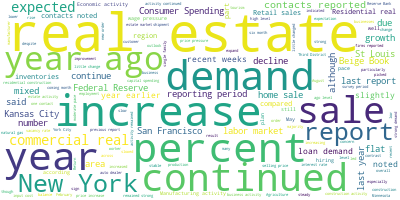

In [13]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(lstFileContents)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=12000000, contour_width=10, 
                      contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


In [14]:
wordcloud.words_

{'real estate': 1.0,
 'increase': 0.6139554794520548,
 'demand': 0.5545376712328767,
 'percent': 0.5453767123287672,
 'year': 0.5238869863013699,
 'continued': 0.5161815068493151,
 'sale': 0.488527397260274,
 'year ago': 0.4699486301369863,
 'New York': 0.38553082191780824,
 'report': 0.37876712328767126,
 'commercial real': 0.3761986301369863,
 'expected': 0.3570205479452055,
 'contacts reported': 0.33184931506849313,
 'last year': 0.29726027397260274,
 'last report': 0.29375,
 'decline': 0.2896404109589041,
 'continue': 0.2884417808219178,
 'mixed': 0.2880993150684932,
 'although': 0.28690068493150683,
 'Consumer Spending': 0.2706335616438356,
 'labor market': 0.26720890410958903,
 'due': 0.2662671232876712,
 'Kansas City': 0.26309931506849316,
 'Federal Reserve': 0.25231164383561644,
 'San Francisco': 0.25205479452054796,
 'area': 0.23621575342465753,
 'number': 0.22996575342465753,
 'said': 0.22696917808219177,
 'St Louis': 0.22243150684931506,
 'reporting period': 0.22114726027397

<span style='color:Blue'> Numbers mean importance of relative words </span>

# Stopwords, stemming and tokenization

In [15]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/liqing/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/liqing/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/liqing/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/liqing/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/liqing/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[

[nltk_data]    |   Package omw is already up-to-date!
[nltk_data]    | Downloading package omw-1.4 to
[nltk_data]    |     /Users/liqing/nltk_data...
[nltk_data]    |   Package omw-1.4 is already up-to-date!
[nltk_data]    | Downloading package opinion_lexicon to
[nltk_data]    |     /Users/liqing/nltk_data...
[nltk_data]    |   Package opinion_lexicon is already up-to-date!
[nltk_data]    | Downloading package panlex_swadesh to
[nltk_data]    |     /Users/liqing/nltk_data...
[nltk_data]    |   Package panlex_swadesh is already up-to-date!
[nltk_data]    | Downloading package paradigms to
[nltk_data]    |     /Users/liqing/nltk_data...
[nltk_data]    |   Package paradigms is already up-to-date!
[nltk_data]    | Downloading package pe08 to
[nltk_data]    |     /Users/liqing/nltk_data...
[nltk_data]    |   Package pe08 is already up-to-date!
[nltk_data]    | Downloading package perluniprops to
[nltk_data]    |     /Users/liqing/nltk_data...
[nltk_data]    |   Package perluniprops is alre

[nltk_data]    |   Package wordnet31 is already up-to-date!
[nltk_data]    | Downloading package wordnet_ic to
[nltk_data]    |     /Users/liqing/nltk_data...
[nltk_data]    |   Package wordnet_ic is already up-to-date!
[nltk_data]    | Downloading package words to
[nltk_data]    |     /Users/liqing/nltk_data...
[nltk_data]    |   Package words is already up-to-date!
[nltk_data]    | Downloading package ycoe to
[nltk_data]    |     /Users/liqing/nltk_data...
[nltk_data]    |   Package ycoe is already up-to-date!
[nltk_data]    | 
[nltk_data]  Done downloading collection all


True

In [16]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

179

In [17]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [18]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [19]:
# add FRB cities as stopwords. Review clusters and add city names
more_stop_words = ['New York','Kansas City','San Francisco','Boston']
for w in more_stop_words:
    x = stemmer.stem(w)
    stopwords.append(x)

In [20]:
# add months as stop words. Review clusters and add months or other redundant information
more_stop_words = ['January','February','October']
for w in more_stop_words:
    x = stemmer.stem(w)
    stopwords.append(x)

In [21]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [22]:
# define a tokenizer and stemmer which returns the set of stems in the text 
#                                                         that it is passed
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is 
    # caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) 
              for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, 
    #                                                     raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [23]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is 
    # caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) 
              for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, 
    #                                                        raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [24]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for text in lstFileContents:
    allwords_stemmed = tokenize_and_stem(text)
    totalvocab_stemmed.extend(allwords_stemmed)
    allwords_tokenized = tokenize_only(text)
    totalvocab_tokenized.extend(allwords_tokenized)

In [25]:
totalvocab_tokenized

['frb',
 'beige',
 'book',
 'full',
 'report',
 'october',
 'summary',
 'of',
 'commentary',
 'oncurrent',
 'economic',
 'conditionsby',
 'federal',
 'reserve',
 'district',
 'summary',
 'prepared',
 'at',
 'the',
 'federal',
 'reserve',
 'bank',
 'of',
 'minneapolis',
 'based',
 'on',
 'information',
 'collected',
 'before',
 'october',
 'this',
 'document',
 'summarizes',
 'comments',
 'received',
 'from',
 'businesses',
 'and',
 'other',
 'contacts',
 'outside',
 'the',
 'federal',
 'reserve',
 'and',
 'is',
 'not',
 'a',
 'commentary',
 'on',
 'the',
 'views',
 'of',
 'federal',
 'reserve',
 'officials',
 'moderate',
 'expansion',
 'of',
 'business',
 'activity',
 'characterizes',
 'the',
 'economy',
 'in',
 'most',
 'federal',
 'reserve',
 'districts',
 'but',
 'on',
 'balance',
 'the',
 'pace',
 'of',
 'growth',
 'reportedly',
 'has',
 'slowed',
 'somewhat',
 'slower',
 'growth',
 'is',
 'reported',
 'in',
 'the',
 'southwest',
 'and',
 'along',
 'the',
 'eastern',
 'seaboard',
 

In [26]:
totalvocab_stemmed

['frb',
 'beig',
 'book',
 'full',
 'report',
 'octob',
 'summari',
 'of',
 'commentari',
 'oncurr',
 'econom',
 'conditionsbi',
 'feder',
 'reserv',
 'district',
 'summari',
 'prepar',
 'at',
 'the',
 'feder',
 'reserv',
 'bank',
 'of',
 'minneapoli',
 'base',
 'on',
 'inform',
 'collect',
 'befor',
 'octob',
 'this',
 'document',
 'summar',
 'comment',
 'receiv',
 'from',
 'busi',
 'and',
 'other',
 'contact',
 'outsid',
 'the',
 'feder',
 'reserv',
 'and',
 'is',
 'not',
 'a',
 'commentari',
 'on',
 'the',
 'view',
 'of',
 'feder',
 'reserv',
 'offici',
 'moder',
 'expans',
 'of',
 'busi',
 'activ',
 'character',
 'the',
 'economi',
 'in',
 'most',
 'feder',
 'reserv',
 'district',
 'but',
 'on',
 'balanc',
 'the',
 'pace',
 'of',
 'growth',
 'report',
 'has',
 'slow',
 'somewhat',
 'slower',
 'growth',
 'is',
 'report',
 'in',
 'the',
 'southwest',
 'and',
 'along',
 'the',
 'eastern',
 'seaboard',
 'except',
 'for',
 'new',
 'england',
 'the',
 'midwest',
 'continu',
 'to',
 'show

In [27]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, 
                                  index = totalvocab_stemmed)

In [28]:
vocab_frame

words
frb            frb
beig         beige
book          book
full          full
report      report
...            ...
feedback  feedback
form          form
last          last
updat       update
decemb    december

[3219653 rows x 1 columns]

In [67]:
len(stopwords)

186

# Vectorization using TF-IDF

In [29]:
# Make a note of the warning. 179 stopwords is a fairly small list of stopwords.

from sklearn.feature_extraction.text import TfidfVectorizer
# turn our cleaned text into numerical data so that we can perform 
#                                          statistical analysis on it.
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                min_df=0.2, stop_words=stopwords,
                use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(lstFileContents)

/Users/liqing/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'ani', 'becaus', 'befor', 'c', 'could', 'doe', 'dure', 'francisco', 'kansa', 'might', 'must', "n't", 'need', 'new', 'onc', 'onli', 'ourselv', 'san', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'york', 'yourselv'] not in stop_words.
  warnings.warn(


# Distance Measurement

In [30]:
tfidf_matrix.shape

(203, 10445)

In [31]:
print(tfidf_matrix[0])

  (0, 3869)	0.012753745810360172
  (0, 3600)	0.012753745810360172
  (0, 3622)	0.012753745810360172
  (0, 7015)	0.012753745810360172
  (0, 8989)	0.012753745810360172
  (0, 1713)	0.012753745810360172
  (0, 260)	0.012753745810360172
  (0, 1454)	0.012753745810360172
  (0, 7028)	0.008454709364996158
  (0, 5988)	0.008454709364996158
  (0, 9796)	0.008454709364996158
  (0, 8277)	0.008454709364996158
  (0, 5330)	0.013077759070875593
  (0, 2878)	0.013542798507256934
  (0, 4576)	0.012066339692211268
  (0, 9734)	0.013077759070875593
  (0, 9458)	0.013665667871790339
  (0, 8130)	0.007511623472021996
  (0, 3892)	0.0232487740777728
  (0, 8576)	0.0232487740777728
  (0, 4356)	0.011796807861337305
  (0, 446)	0.01330522241862014
  (0, 8843)	0.0118851500704726
  (0, 5080)	0.009049163888672756
  (0, 3061)	0.013665667871790339
  :	:
  (0, 7751)	0.03476223422594566
  (0, 8736)	0.5062975553151687
  (0, 1125)	0.00977782518632439
  (0, 9648)	0.06321338094447286
  (0, 9991)	0.021179098742375488
  (0, 4839)	0.0257

In [32]:
tfidf_matrix.todense()

matrix([[0.03165566, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.00750061, 0.00869626, ..., 0.00922747, 0.00922747,
         0.        ],
        [0.01536277, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.00610425, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.01758443, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.01169051]])

In [33]:
tfidf_matrix.todense().shape

(203, 10445)

In [34]:
print(tfidf_matrix[137,:].toarray())

[[0.         0.01309357 0.00759039 ... 0.         0.         0.00682582]]


In [35]:
tfidf_matrix[137,:].toarray().shape

(1, 10445)

# Cosine Similarity

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [68]:
cosine_similarity(tfidf_matrix)

array([[1.        , 0.18423108, 0.25070894, ..., 0.22098783, 0.22765212,
        0.30313913],
       [0.18423108, 1.        , 0.32996407, ..., 0.30366392, 0.27303537,
        0.16657713],
       [0.25070894, 0.32996407, 1.        , ..., 0.418401  , 0.40316981,
        0.21701323],
       ...,
       [0.22098783, 0.30366392, 0.418401  , ..., 1.        , 0.38261477,
        0.19516237],
       [0.22765212, 0.27303537, 0.40316981, ..., 0.38261477, 1.        ,
        0.27197779],
       [0.30313913, 0.16657713, 0.21701323, ..., 0.19516237, 0.27197779,
        1.        ]])

In [69]:
dist

array([[-2.22044605e-16,  8.15768919e-01,  7.49291061e-01, ...,
         7.79012166e-01,  7.72347878e-01,  6.96860866e-01],
       [ 8.15768919e-01, -6.66133815e-16,  6.70035929e-01, ...,
         6.96336084e-01,  7.26964633e-01,  8.33422874e-01],
       [ 7.49291061e-01,  6.70035929e-01,  1.11022302e-16, ...,
         5.81599003e-01,  5.96830186e-01,  7.82986772e-01],
       ...,
       [ 7.79012166e-01,  6.96336084e-01,  5.81599003e-01, ...,
        -6.66133815e-16,  6.17385231e-01,  8.04837632e-01],
       [ 7.72347878e-01,  7.26964633e-01,  5.96830186e-01, ...,
         6.17385231e-01, -4.44089210e-16,  7.28022213e-01],
       [ 6.96860866e-01,  8.33422874e-01,  7.82986772e-01, ...,
         8.04837632e-01,  7.28022213e-01, -2.22044605e-16]])

In [71]:
dist.shape

(203, 203)

In [72]:
type(dist)

numpy.ndarray

In [73]:
df=pd.DataFrame(dist)

In [74]:
#import seaborn as sn
#import matplotlib.pyplot as plt
#sn.heatmap(dist, annot=True)
#plt.show()

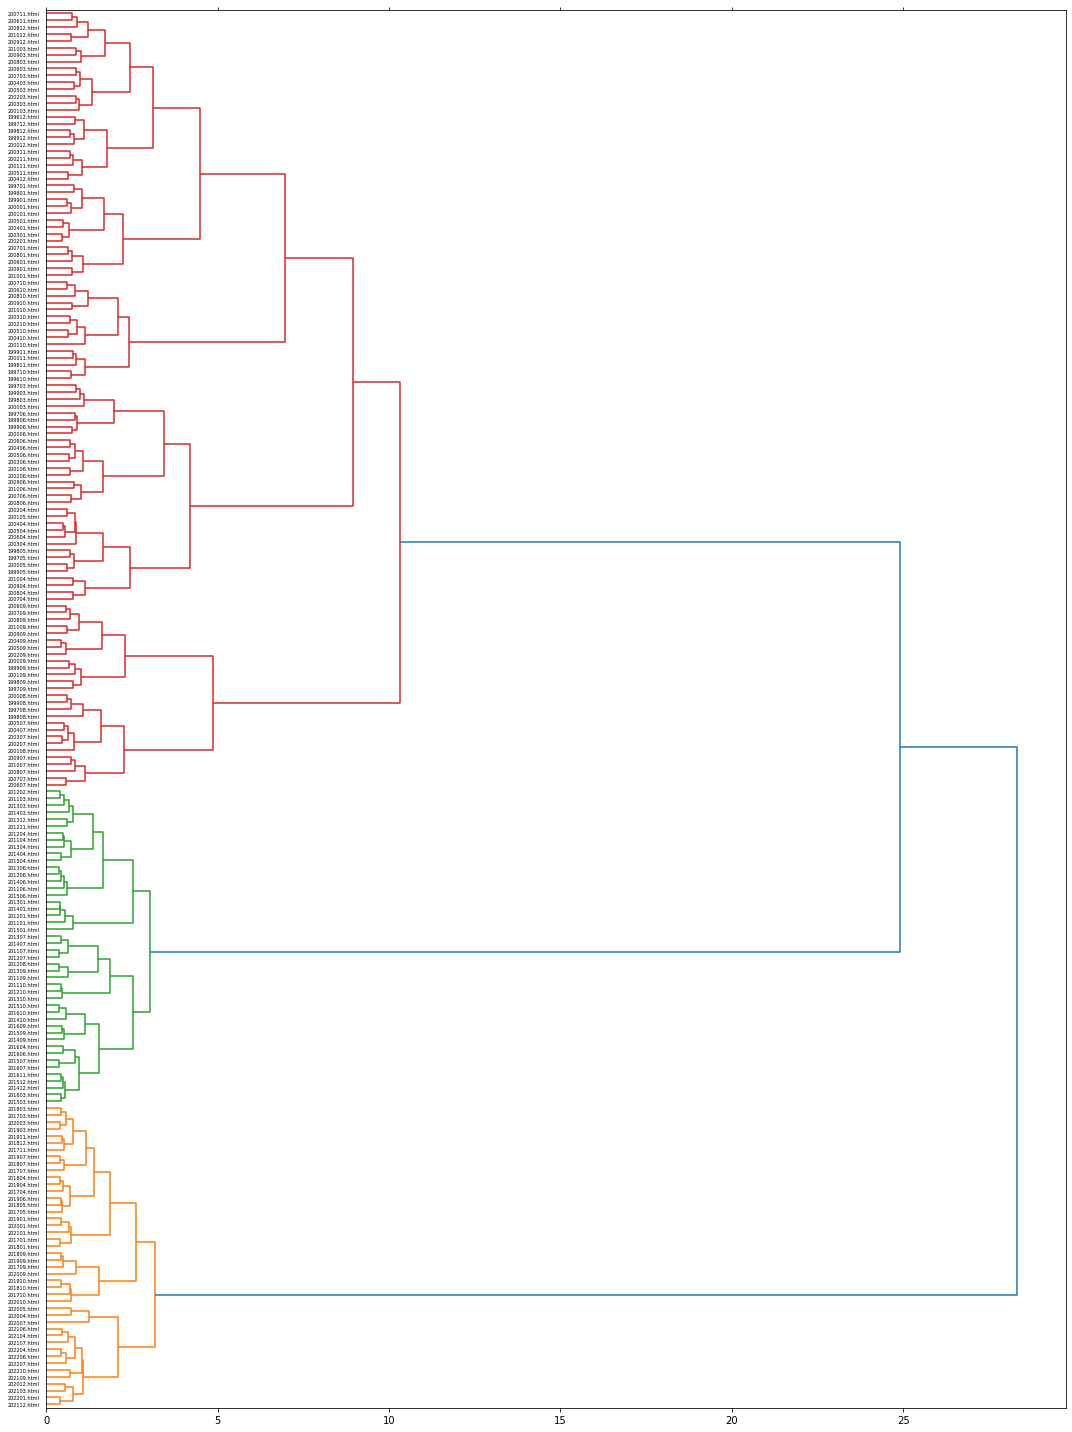

In [75]:
# Document level analysis
%matplotlib inline
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=lstFileNames);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

# K-means clustering

In [76]:
# Take all the documents and cluster the documents by num_clusters by its content 
#                                                         (6,785 words and frequencies)

from sklearn.cluster import KMeans

num_clusters = 7

km = KMeans(n_clusters=num_clusters)

#%time km.fit(tfidf_matrix)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [77]:
clusters

[0,
 2,
 3,
 1,
 4,
 0,
 5,
 0,
 1,
 2,
 5,
 2,
 2,
 4,
 0,
 4,
 1,
 6,
 0,
 4,
 1,
 6,
 2,
 2,
 1,
 2,
 4,
 1,
 5,
 4,
 1,
 2,
 1,
 3,
 1,
 4,
 6,
 3,
 2,
 4,
 1,
 2,
 3,
 3,
 5,
 4,
 2,
 4,
 2,
 6,
 2,
 1,
 4,
 3,
 1,
 2,
 3,
 1,
 5,
 6,
 0,
 1,
 1,
 3,
 4,
 1,
 2,
 0,
 5,
 4,
 3,
 4,
 1,
 6,
 4,
 3,
 1,
 6,
 2,
 3,
 2,
 1,
 4,
 1,
 3,
 4,
 1,
 1,
 3,
 2,
 2,
 5,
 4,
 1,
 3,
 2,
 1,
 2,
 0,
 4,
 6,
 4,
 4,
 4,
 1,
 1,
 4,
 6,
 2,
 1,
 0,
 2,
 1,
 1,
 4,
 2,
 5,
 2,
 0,
 4,
 3,
 2,
 0,
 1,
 5,
 2,
 3,
 1,
 5,
 3,
 3,
 4,
 2,
 1,
 2,
 2,
 1,
 1,
 4,
 4,
 6,
 2,
 1,
 5,
 1,
 4,
 4,
 1,
 2,
 2,
 0,
 4,
 3,
 6,
 4,
 6,
 5,
 1,
 0,
 0,
 5,
 2,
 4,
 3,
 1,
 4,
 4,
 2,
 4,
 2,
 6,
 2,
 3,
 1,
 2,
 6,
 1,
 4,
 2,
 5,
 2,
 1,
 0,
 1,
 2,
 2,
 3,
 1,
 4,
 2,
 1,
 4,
 3,
 3,
 4,
 4,
 2,
 3,
 4,
 3,
 1,
 3,
 4]

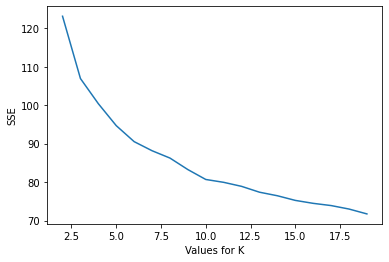

In [78]:
# When the curve flattens out, it signifies optimal number of clusters
sse={}
#for k in np.arange(2,20,1):
for k in np.arange(2,20,1): # categorize the document. Hawkish/dovish could just be 2.
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tfidf_matrix)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()))
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.show();

In [79]:
BeigeBooks = { 'fileNames': lstFileNames, 'fileIndex': fileIndex, 
             'contents': lstFileContents, 'cluster':   clusters, 
                                          'sections':  lstFileNames }

dfBeigeBooks = pd.DataFrame(BeigeBooks, index = [clusters] , 
                columns = ['fileIndex', 'fileNames', 'cluster', 'sections'])

In [80]:
dfBeigeBooks.describe()

fileIndex     cluster
count  203.000000  203.000000
mean   101.000000    2.665025
std     58.745213    1.672760
min      0.000000    0.000000
25%     50.500000    1.000000
50%    101.000000    2.000000
75%    151.500000    4.000000
max    202.000000    6.000000

In [81]:
terms = tfidf_vectorizer.get_feature_names()

/Users/liqing/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [82]:
terms

["'s apparel",
 "'s busi",
 "'s busi inflat",
 "'s co-op",
 "'s co-op condo",
 "'s commerci",
 "'s commerci real",
 "'s corn",
 "'s economi",
 "'s economi continu",
 "'s hous",
 "'s hous market",
 "'s key",
 "'s key polici",
 "'s level",
 "'s major",
 "'s manufactur",
 "'s manufactur sector",
 "'s market",
 "'s metropolitan",
 "'s metropolitan area",
 "'s new",
 "'s new 's",
 "'s next",
 "'s next site",
 "'s offic",
 "'s offic market",
 "'s pace",
 "'s rate",
 "'s rental",
 "'s rental market",
 "'s sale",
 "'s servic",
 "'s servic sector",
 "'s survey",
 "'s tourism",
 '16,1998beig',
 '16,1998beig book',
 '16,1998beig book august',
 '1996beig',
 '1996beig book',
 '1996beig book home',
 '1997beig',
 '1997beig book',
 '1997beig book 1997beig',
 '1997beig book 22,1997beig',
 '1997beig book august',
 '1997beig book june',
 '1997beig book march',
 '1997beig book may',
 '1997beig book septemb',
 '1998beig',
 '1998beig book',
 '1998beig book 1998beig',
 '1998beig book decemb',
 '1998beig book

In [83]:
num_clusters

7

In [84]:
from __future__ import print_function
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :100]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        print()
    print()
    print("Cluster %d fileNames:" % i, end='')
    for fileName in dfBeigeBooks.loc[i]['fileNames'].tolist():
        print(' %s,' % fileName, end='')
        print()
    print()

Top terms per cluster:

Cluster 0 words: b'september',
 b'august',
 b'returned',
 b'hurricanes',
 b'august',
 b'third',
 b'damage',
 b'next',
 b'disruptions',
 b'holiday',
 b'last',
 b'va.',
 b'storm',
 b'contacts',
 b'told',
 b'told',
 b'fall',
 b'cooling',
 b'soybeans',
 b'tax',
 b'report',
 b'labor',
 b'heating',
 b'computers',
 b'strike',
 b'n.c.',
 b'port',
 b'mississippi',
 b'upcoming',
 b'dallas',
 b'total',
 b'back-to-school',
 b'fourth',
 b'francisco',
 b'san',
 b'virtually',
 b'consulting',
 b'pastures',
 b'feeding',
 b'department',
 b'cancellations',
 b'tightening',
 b'programs',
 b'upcoming',
 b'temporary',
 b'region',
 b'warm',
 b'report',
 b'last',
 b'last',
 b'force',
 b'apparel',
 b'july',
 b'indiana',
 b'lending',
 b'machine',
 b'tight',
 b'begun',
 b'west',
 b'obtain',
 b'remains',
 b'richmond',
 b'energy',
 b'recent',
 b'rest',
 b'during',
 b'announced',
 b'stocks',
 b'credit',
 b'asia',
 b'market',
 b'tight',
 b'past',
 b'bonuses',
 b'soybeans',
 b'tighter',
 b'dry'

 b'march',
 b'st.',
 b'usual',
 b'virtually',
 b'ranchers',
 b'winter',
 b'tightening',
 b'report',
 b'mortgage',
 b'telecommunications',
 b'minneapolis',
 b'minneapolis',
 b'during',
 b'holding',

Cluster 4 fileNames: 199903.html,
 200601.html,
 200103.html,
 200912.html,
 200401.html,
 200801.html,
 200211.html,
 200303.html,
 199703.html,
 200611.html,
 200703.html,
 200001.html,
 199712.html,
 199801.html,
 199912.html,
 200903.html,
 200503.html,
 200201.html,
 201001.html,
 200812.html,
 200111.html,
 200003.html,
 200412.html,
 200701.html,
 199803.html,
 201003.html,
 200203.html,
 200311.html,
 200501.html,
 200901.html,
 199901.html,
 199612.html,
 200101.html,
 201012.html,
 200603.html,
 200711.html,
 200301.html,
 200803.html,
 200012.html,
 200511.html,
 200403.html,
 199701.html,
 199812.html,

Cluster 5 words: b'april',
 b'april',
 b'returned',
 b'june',
 b'march',
 b'cooling',
 b'sales',
 b'software',
 b'san',
 b'francisco',
 b'memory',
 b'march',
 b'estate',
 b'real',

# Topic Modeling

In [85]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [86]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [87]:
#!conda install -c conda-forge gensim

In [88]:
#Latent Dirichlet Allocation implementation with Gensim
from gensim import corpora, models, similarities 

#remove proper names
preprocess = [strip_proppers(doc) for doc in lstFileContents]

#%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]
tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]
texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

In [89]:
texts

[['report',
  'base',
  'inform',
  'collect',
  'befor',
  'document',
  'summar',
  'comment',
  'receiv',
  'busi',
  'contact',
  'outsid',
  'commentari',
  'view',
  'offici',
  'expans',
  'busi',
  'activ',
  'character',
  'economi',
  'district',
  'balanc',
  'pace',
  'growth',
  'report',
  'slow',
  'somewhat',
  'growth',
  'report',
  'along',
  'eastern',
  'seaboard',
  'except',
  'continu',
  'show',
  'moder',
  'strong',
  'growth',
  'two',
  'district',
  'lag',
  'much',
  'rest',
  'nation',
  'first',
  'half',
  '1990s',
  'indic',
  'improv',
  'perform',
  'indic',
  'signific',
  'price',
  'increas',
  'raw',
  'materi',
  'good',
  'servic',
  'report',
  'upward',
  'pressur',
  'wage',
  'widespread',
  'balanc',
  'consum',
  'spend',
  'best',
  'character',
  'moder',
  'sign',
  'strength',
  'area',
  'sale',
  'boom',
  'consider',
  'variat',
  'pattern',
  'spend',
  'region',
  'categori',
  'merchandis',
  'describ',
  'double-digit',
  'gro

In [56]:
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.8)
corpus = [dictionary.doc2bow(text) for text in texts]

In [57]:
corpus[0][0:]

[(0, 1),
 (1, 2),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 2),
 (7, 1),
 (8, 1),
 (9, 2),
 (10, 3),
 (11, 1),
 (12, 1),
 (13, 2),
 (14, 1),
 (15, 2),
 (16, 2),
 (17, 2),
 (18, 1),
 (19, 2),
 (20, 1),
 (21, 1),
 (22, 2),
 (23, 1),
 (24, 7),
 (25, 2),
 (26, 2),
 (27, 1),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 2),
 (33, 1),
 (34, 1),
 (35, 2),
 (36, 2),
 (37, 1),
 (38, 1),
 (39, 1),
 (40, 1),
 (41, 6),
 (42, 1),
 (43, 5),
 (44, 4),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 4),
 (49, 1),
 (50, 1),
 (51, 1),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 1),
 (57, 1),
 (58, 4),
 (59, 1),
 (60, 1),
 (61, 5),
 (62, 4),
 (63, 1),
 (64, 1),
 (65, 1),
 (66, 1),
 (67, 1),
 (68, 1),
 (69, 1),
 (70, 2),
 (71, 2),
 (72, 1),
 (73, 2),
 (74, 1),
 (75, 2),
 (76, 1),
 (77, 1),
 (78, 1),
 (79, 1),
 (80, 1),
 (81, 1),
 (82, 1),
 (83, 1),
 (84, 1),
 (85, 1),
 (86, 4),
 (87, 1),
 (88, 1),
 (89, 1),
 (90, 1),
 (91, 6),
 (92, 1),
 (93, 2),
 (94, 1),
 (95, 1),
 (96, 4),
 (97, 1),
 (98, 1),
 (99, 1),
 (100, 1),

In [58]:
#%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)
lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

In [59]:
topics = lda_model.print_topics(5, num_words=20)
topics

[(0,
  '0.010*"tariff" + 0.009*"elev" + 0.009*"visit" + 0.009*"disrupt" + 0.008*"challeng" + 0.007*"pandem" + 0.006*"leisur" + 0.006*"pre-pandem" + 0.006*"wholesal" + 0.005*"issu" + 0.005*"constraint" + 0.005*"retain" + 0.004*"nonmanufactur" + 0.004*"restrict" + 0.004*"struggl" + 0.003*"nonfinanci" + 0.003*"amid" + 0.003*"abil" + 0.003*"observ" + 0.003*"broad"'),
 (1,
  '0.006*"us" + 0.005*"told" + 0.005*"tax" + 0.004*"recoveri" + 0.004*"healthcar" + 0.003*"fourth" + 0.003*"elev" + 0.003*"uncertain" + 0.003*"lay" + 0.003*"legal" + 0.003*"coal" + 0.003*"upcom" + 0.003*"obtain" + 0.003*"contain" + 0.003*"year-to-d" + 0.003*"softwar" + 0.003*"feed" + 0.003*"consult" + 0.003*"transact" + 0.003*"special"'),
 (2,
  '0.008*"broker" + 0.008*"coal" + 0.006*"multifamili" + 0.005*"healthcar" + 0.005*"dollar" + 0.004*"elev" + 0.004*"port" + 0.004*"cargo" + 0.004*"upstat" + 0.004*"service-sector" + 0.004*"mild" + 0.004*"consult" + 0.003*"replac" + 0.003*"contain" + 0.003*"wholesal" + 0.003*"skip" +

In [60]:
topics_matrix = lda_model.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix)

/var/folders/g2/pm5hbqqx7_bdfcs1r60s5f440000gn/T/ipykernel_76986/4199977372.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  topics_matrix = np.array(topics_matrix)


In [61]:
#topics_matrix[2][1][2][0]
for i in range(len(topics_matrix)):
    topic_words =''
    for j in range(len(topics_matrix[i][1])):
        topic_words = topic_words + topics_matrix[i][1][j][0] +  ' ' 
    print('Topic '  + str(i+1) + ': ' + topic_words)

Topic 1: tariff elev visit disrupt challeng pandem leisur pre-pandem wholesal issu constraint retain nonmanufactur restrict struggl nonfinanci amid abil observ broad 
Topic 2: us told tax recoveri healthcar fourth elev uncertain lay legal coal upcom obtain contain year-to-d softwar feed consult transact special 
Topic 3: broker coal multifamili healthcar dollar elev port cargo upstat service-sector mild consult replac contain wholesal skip global remaind nonfinanci hog 
Topic 4: district realtor comput rain damag cool telecommun merchant fourth textil warm moistur dollar model pastur appreci countri southern unusu usual 
Topic 5: big-data envelop preemptiv dark redesign rebalanc vintag lending-bas pistachio mid-to-upp choic transmiss indefinit adventur flock white-collar pond veterinari infus non-techn 


In [62]:
for i in range(len(topics_matrix)):
    for j in range(len(topics_matrix[i][1])):
        print(str(i+1) + ', ' + topics_matrix[i][1][j][0] + ', ' + str(topics_matrix[i][1][j][1]))

1, tariff, 0.009783174
1, elev, 0.009414674
1, visit, 0.00936534
1, disrupt, 0.0093386
1, challeng, 0.008119563
1, pandem, 0.0066518197
1, leisur, 0.00646809
1, pre-pandem, 0.0064601484
1, wholesal, 0.006431249
1, issu, 0.005095635
1, constraint, 0.0050040954
1, retain, 0.0046388065
1, nonmanufactur, 0.003673493
1, restrict, 0.0036029455
1, struggl, 0.0035964607
1, nonfinanci, 0.0034523597
1, amid, 0.003337143
1, abil, 0.003331835
1, observ, 0.0032350228
1, broad, 0.003181286
2, us, 0.005812441
2, told, 0.0054627554
2, tax, 0.0047282134
2, recoveri, 0.003524908
2, healthcar, 0.0035173306
2, fourth, 0.0031514952
2, elev, 0.003037372
2, uncertain, 0.0030292904
2, lay, 0.0029810737
2, legal, 0.002860006
2, coal, 0.002842298
2, upcom, 0.002814305
2, obtain, 0.002785826
2, contain, 0.0027564908
2, year-to-d, 0.0027356616
2, softwar, 0.002724499
2, feed, 0.0027221367
2, consult, 0.0026573911
2, transact, 0.0026218796
2, special, 0.002617011
3, broker, 0.007868169
3, coal, 0.007565689
3, mult

In [63]:
filename = resultDirectory + '\\bb_lda_topics.txt'
f = open(filename, 'a')

for i in range(len(topics_matrix)):
    topic_words =''
    for j in range(len(topics_matrix[i][1])):
        topic_words = topic_words + topics_matrix[i][1][j][0] +  ' ' 
    print('Topic '  + str(i+1) + ': ' + topic_words)
    f.write('Topic '  + str(i+1) + ':, ' + topic_words)

Topic 1: tariff elev visit disrupt challeng pandem leisur pre-pandem wholesal issu constraint retain nonmanufactur restrict struggl nonfinanci amid abil observ broad 
Topic 2: us told tax recoveri healthcar fourth elev uncertain lay legal coal upcom obtain contain year-to-d softwar feed consult transact special 
Topic 3: broker coal multifamili healthcar dollar elev port cargo upstat service-sector mild consult replac contain wholesal skip global remaind nonfinanci hog 
Topic 4: district realtor comput rain damag cool telecommun merchant fourth textil warm moistur dollar model pastur appreci countri southern unusu usual 
Topic 5: big-data envelop preemptiv dark redesign rebalanc vintag lending-bas pistachio mid-to-upp choic transmiss indefinit adventur flock white-collar pond veterinari infus non-techn 


In [64]:
filename = resultDirectory + '\\bb_lda_topic_words.txt'
f = open(filename, 'a')

for i in range(len(topics_matrix)):
    for j in range(len(topics_matrix[i][1])):
        print(str(i+1) + ', ' + topics_matrix[i][1][j][0] + ', ' + str(topics_matrix[i][1][j][1]))
        f.write(str(i+1) + ', ' + topics_matrix[i][1][j][0] + ', ' + str(topics_matrix[i][1][j][1]))

f.close()

1, tariff, 0.009783174
1, elev, 0.009414674
1, visit, 0.00936534
1, disrupt, 0.0093386
1, challeng, 0.008119563
1, pandem, 0.0066518197
1, leisur, 0.00646809
1, pre-pandem, 0.0064601484
1, wholesal, 0.006431249
1, issu, 0.005095635
1, constraint, 0.0050040954
1, retain, 0.0046388065
1, nonmanufactur, 0.003673493
1, restrict, 0.0036029455
1, struggl, 0.0035964607
1, nonfinanci, 0.0034523597
1, amid, 0.003337143
1, abil, 0.003331835
1, observ, 0.0032350228
1, broad, 0.003181286
2, us, 0.005812441
2, told, 0.0054627554
2, tax, 0.0047282134
2, recoveri, 0.003524908
2, healthcar, 0.0035173306
2, fourth, 0.0031514952
2, elev, 0.003037372
2, uncertain, 0.0030292904
2, lay, 0.0029810737
2, legal, 0.002860006
2, coal, 0.002842298
2, upcom, 0.002814305
2, obtain, 0.002785826
2, contain, 0.0027564908
2, year-to-d, 0.0027356616
2, softwar, 0.002724499
2, feed, 0.0027221367
2, consult, 0.0026573911
2, transact, 0.0026218796
2, special, 0.002617011
3, broker, 0.007868169
3, coal, 0.007565689
3, mult

In [65]:
##pip install pyLDAvis

In [66]:
import pyLDAvis
#import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis
import pickle 


# Visualize the topics
pyLDAvis.enable_notebook()

num_topics = 5
LDAvis_data_filepath = os.path.join('./result/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './result/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/Users/liqing/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/liqing/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/liqing/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/liqing/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/liqing/opt/anaconda3/lib/pytho

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.053302  0.082707       1        1  30.195788
1      0.074652  0.037417       2        1  28.080952
2      0.092506 -0.007258       3        1  23.571684
0      0.054653 -0.113963       4        1  18.065354
4     -0.275113  0.001097       5        1   0.086221, topic_info=             Term         Freq        Total Category  logprob  loglift
158      district  2783.000000  2783.000000  Default  30.0000  30.0000
1068       tariff   452.000000   452.000000  Default  29.0000  29.0000
1108        visit   584.000000   584.000000  Default  28.0000  28.0000
2775       pandem   299.000000   299.000000  Default  27.0000  27.0000
2781   pre-pandem   291.000000   291.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
5572  lightweight     0.123115     1.867424   Topic5  -7.4634   4.3368
3579  congression     0.123114     2.842079   Topic5  -7.4634   3.9168
5868     lease-up     0.123114     1.867437   Topic5  -7.4634   4.3368
5856       aggrav     0.123114     2.818128   Topic5  -7.4634   3.9253
3600      fighter     0.123111     4.793120   Topic5  -7.4634   3.3942

[393 rows x 6 columns], token_table=      Topic      Freq                                           Term
term                                                                
675       4  0.992726             //research.stlouisfed.org/regecon/
4577      1  0.989951                                           11th
1         1  0.977335                                          1980s
676       2  0.022779                                           20th
676       4  0.956710                                           20th
...     ...       ...                                            ...
1128      4  0.977998  www.richmondfed.org/research/regional_economi
672       1  0.286290                                      year-to-d
672       2  0.440978                                      year-to-d
672       3  0.247040                                      year-to-d
672       4  0.023088                                      year-to-d

[815 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1, 5])